In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from typing import List, Optional
import collections
from prettytable import PrettyTable


In [2]:
DEVICE_USE = "cpu" # "cuda"

# Definitions

In [3]:
# Donde esta la data de los tonos del telefono
FILES = "../data/tektronic-2024" 

# Vamos a procesar solo una señal de tension, asi que vamos a tener solo un canal
SIGNAL_CHANNELS = 1

# Fraccion de muestras que vamos a usar para validar el entrenamiento (no se usan para entrenar)
valid_split = 0.10
# Cantidad de nuestras ve la red neuronal a cada vez, con esta cantidad de muestras va a decidir q tecla se presiono
sample_len = 64

# Nuestra red va a tener filtros de esta cantidad de elementos
kernels = [32,8,4]
# Y va a haber una cantidad de filtros de cada tamaño que elegimos dado por este numero de canales
channels = [14,18,22]



# Hiperparametros de entrenamiento:

# Cantidad de veces voy a pasar TODA la data de entrenamiento por la red
epochs = 50 
# Velocidad con la que actualizo los pesos de la red
lr = 1e-4
# Cantidad de muestras que tomo al mismo tiempo y uso para suavizar el calculo del gradiente
batch_size = 32
# Aca vamos a escribir los archivos de log
TENSORBOARD_FILE = "../untracked/outputs/conv-classifier"
# Aca se va a guardar
SAVE_PATH = "../untracked/outputs/conv-classifier-model"



# Dataset Generation

### Leemos la data

In [4]:

tones_dict = dict()
for folder in os.listdir(FILES):
    subfolder = os.path.join(FILES,folder)

    if 'TIEMPO' in subfolder:
        
        for file in os.listdir(subfolder):

            if '.CSV' in file:
                data=np.genfromtxt(os.path.join(subfolder,file),delimiter=',')

                name = subfolder.split("Medicion Tono ")[-1].split(" - TIEMPO")[0]
                tones_dict[name] = data[:,4] # Tono

                tiempo  =data[:,3]
                
sample_rate = (tiempo[1]-tiempo[0])
f_muestreo = 1/sample_rate



In [5]:
# sort the dictionary
tones_dict = collections.OrderedDict(sorted(tones_dict.items()))

In [6]:
print("la red va a ver %0.2f ms de señal"%(sample_len*sample_rate*1e3))

la red va a ver 2.56 ms de señal


In [7]:
f_muestreo/sample_len

390.6250000000159

In [8]:
# Calculo el maximo y minimo de las señales
max_min = [0,0]
for clase, key in enumerate(tones_dict.keys()):
    if max(tones_dict[key]) > max_min[0]:
        max_min[0] = max(tones_dict[key])
    if min(tones_dict[key]) > max_min[1]:
        max_min[1] = min(tones_dict[key])


### Creamos un dataset de pytorch

In [9]:
# Las clases a clasificar son la cantidad de teclas que grabamos
NUM_CLASES = len(list(tones_dict.keys()))


train_samples_list = list()
train_targets_list = list()
validation_samples_list = list()
validation_targets_list = list()
for num_draws in range(25):

    for clase, key in enumerate(tones_dict.keys()):
        # Normalizamos
        signa_use = tones_dict[key]
        signa_use = (signa_use-max_min[1])/(max_min[0]-max_min[1])

        # Cortamos y agregamos al datasey
        total_len = len(signa_use)

        total_samples = np.floor(total_len/sample_len).astype(int)
        valid_samples = np.round(total_samples*valid_split).astype(int)

        for sample_t in range(total_samples):

            # Select random start for draw
            start_rand = int((np.random.random(1)-0.5)*100)
            this_start = (sample_t*sample_len)+start_rand
            this_end = ((sample_t+1)*sample_len)+start_rand
            if this_start < 0:
                continue
            if this_end >= total_len:
                continue

            # crop sample
            this_sample = np.expand_dims(signa_use[this_start:this_end], axis =0)
            # one-hot target
            this_target = np.zeros((NUM_CLASES))
            this_target[clase] = 1
            # Assign
            if sample_t <= valid_samples:
                validation_samples_list.append(this_sample)
                validation_targets_list.append(this_target)
            else:
                train_samples_list.append(this_sample)
                train_targets_list.append(this_target)
                
train_samples = np.array(train_samples_list)
print(train_samples.shape)
train_targets = np.array(train_targets_list)
print(train_targets.shape)
validation_samples = np.array(validation_samples_list)
print(validation_samples.shape)
validation_targets = np.array(validation_targets_list)
print(validation_targets.shape)

tensor_x = torch.Tensor(train_samples) # transform to torch tensor
tensor_y = torch.Tensor(train_targets)
train_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
tensor_x = torch.Tensor(validation_samples) # transform to torch tensor
tensor_y = torch.Tensor(validation_targets)
validation_dataset = TensorDataset(tensor_x,tensor_y) # create your datset




(10059, 1, 64)
(10059, 12)
(1359, 1, 64)
(1359, 12)


# Neural Network Creation

Aca creamos la red neuronal, va a ser una red convolucional, la cual aprende formas de señal en cada uno de sus filtros (canales de los layers torch.nn.Conv1d)

In [10]:
class ConvClassifier(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernels: List[int] =  [],
        channels: List[int] =  [],
    ):
        super().__init__()

        self.conv_layers = list()

        assert len(kernels) == len(channels)

        # Aca proceamos la señal con una serie de filtros y vamos reduciendo el tamaño del vector de entrada
        self.conv1 = torch.nn.Conv1d(in_channels, channels[0], kernels[0],padding="same")
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool1d(kernel_size=2)
        self.conv2 = torch.nn.Conv1d(channels[0], channels[1], kernels[1],padding="same")
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool1d(kernel_size=2)
        self.conv3 = torch.nn.Conv1d(channels[1], channels[2], kernels[2],padding="same")
        self.act3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool1d(kernel_size=2)

        # Esto solo transforma un tensor (matriz de mas de 2 dimenciones) en un vector
        self.flat = torch.nn.Flatten()

        # Este es el ultimo layer clasificador que aprende, mas que nada sirve para adaptar la salida de los layers anteriores a la cantidad de clases a clasificar.
        self.linear = torch.nn.Linear(channels[-1]*int(sample_len/(2**len(kernels))), out_channels)

        # Y esto convierte una salida de numeros arbitrarios en una distribucion de probabilidad (ponele)
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        # Esto es lo q se hace cuando se llama a la clase
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        x = self.flat(x)
        x = self.linear(x)
        return self.softmax(x)


In [11]:
# Ahora instanciamos el modelo
model: torch.nn.Module = (
    ConvClassifier(
        in_channels=SIGNAL_CHANNELS,
        out_channels=NUM_CLASES,
        kernels = kernels,
        channels = channels
    )
    .to(DEVICE_USE)
)




In [12]:
# Checkeamos que ande con data random
x = torch.randn(8, 1, sample_len).to(DEVICE_USE)
y = model(x)
print(x.shape, y.shape)

torch.Size([8, 1, 64]) torch.Size([8, 12])


/home/rawthil/.cache/pypoetry/virtualenvs/nn4fsm-iQeem2RF-py3.10/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


In [13]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    448     |
|   conv1.bias  |     14     |
|  conv2.weight |    2016    |
|   conv2.bias  |     18     |
|  conv3.weight |    1584    |
|   conv3.bias  |     22     |
| linear.weight |    2112    |
|  linear.bias  |     12     |
+---------------+------------+
Total Trainable Params: 6226


6226

# Training

In [14]:
# definimos la funcion ojetivo como la entropia cruzada
loss: torch.nn.Module = torch.nn.CrossEntropyLoss()
# y al optimizador como ADAM
optimizer: torch.optim.Optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [15]:
# Creamos las clases "DataLoader" a partir de los datasets definidos anteriormente para que controlen los batches de entrenmiento y validacion. 
train_dataloader = DataLoader(train_dataset,
                                   batch_size=batch_size,
                                    shuffle=True,)


validation_dataloader = DataLoader(validation_dataset,
                                   batch_size=batch_size,
                                    shuffle=True,)


In [16]:
# Creamos una metrica para calcular el Accurracy, cuantas señales la red esta clasificando correctamente. 
# No se usa para entrenar, solo para que lo veamos nosotros.
class Accuracy:
    correct: int
    total: int

    def __init__(self) -> None:
        self.correct = 0
        self.total = 0

    def update(self, logits: torch.Tensor, labels: torch.Tensor) -> None:
        oh = torch.nn.functional.one_hot(logits.argmax(dim=-1), num_classes=labels.shape[-1]) 
        self.correct += int((oh*labels).sum())
        self.total += labels.shape[0]
        return None

    def compute(self) -> float:
        return self.correct / self.total

    def reset(self) -> None:
        self.correct = 0
        self.total = 0
        return None

In [17]:
# Declaramos todo lo que vamos a hacer en los pasos de entrenamiento y validacion

@torch.enable_grad()
def train_step(
    model: torch.nn.Module,
    train_data: DataLoader,
    loss: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    writer: SummaryWriter,
    epoch: int,
    device: torch.device,
    accuracy: Accuracy = Accuracy(),
) -> None:
    """
    This function train the model.

    Args:
        model: model to train.
        train_data: dataloader of train data.
        loss: loss function.
        optimizer: optimizer.
        writer: writer for tensorboard.
        epoch: epoch of the training.
        device: device for running operations.
    """
    # Training
    model.train()
    losses = []

    for inputs, targets in train_data:
        inputs, targets = inputs.to(device), targets.to(device)

        # forward
        outputs = model(inputs)

        # Compute loss
        loss_value = loss(outputs, targets)
        losses.append(loss_value.item())

        optimizer.zero_grad()
        loss_value.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        accuracy.update(outputs, targets)

    # Write to tensorboard
    writer.add_scalar("train/loss", np.mean(losses), epoch)
    writer.add_scalar("train/accuracy", accuracy.compute(), epoch)
    accuracy.reset()


@torch.no_grad()
def val_step(
    model: torch.nn.Module,
    val_data: DataLoader,
    loss: torch.nn.Module,
    scheduler: Optional[torch.optim.lr_scheduler.LRScheduler],
    writer: SummaryWriter,
    epoch: int,
    device: torch.device,
    accuracy: Accuracy = Accuracy(),
) -> None:
    """
    This function train the model.

    Args:
        model: model to train.
        val_data: dataloader of validation data.
        loss: loss function.
        scheduler: scheduler.
        writer: writer for tensorboard.
        epoch: epoch of the training.
        device: device for running operations.
    """
    # Validation
    model.eval()
    losses = []

    with torch.no_grad():
        for inputs, targets in val_data:
            inputs, targets = inputs.to(device), targets.to(device)

            # forward
            outputs = model(inputs)

            # Compute loss
            loss_value = loss(outputs, targets)
            losses.append(loss_value.item())

            # Update accuracy
            accuracy.update(outputs, targets)

    if scheduler is not None:
        scheduler.step()

    # Write to tensorboard
    writer.add_scalar("val/loss", np.mean(losses), epoch)
    writer.add_scalar("val/accuracy", accuracy.compute(), epoch)
    accuracy.reset()

In [18]:
# Creamos un "escritor", el cual usaremos para escribir los archivos de TensorBoard, una aplicacion que nos permite observar cosas durante el entrenamiento de la red.
writer = SummaryWriter(TENSORBOARD_FILE)
# Instanciamos la clase de accurracy
accuracy = Accuracy()
# define an empty scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=45, gamma=0.5)
# Train the model
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    # call train step
    train_step(
        model, train_dataloader, loss, optimizer, writer, epoch, DEVICE_USE, accuracy
    )
    # call val step
    val_step(model, validation_dataloader, loss, scheduler, writer, epoch, DEVICE_USE, accuracy)
    # clear the GPU cache
    torch.cuda.empty_cache()

100%|██████████| 50/50 [01:49<00:00,  2.18s/it]


In [19]:
torch.save(model.state_dict(), SAVE_PATH)

# Reload Model, just because

In [20]:
MODEL_CHKP = SAVE_PATH #+ "-OK"
model.load_state_dict(torch.load(MODEL_CHKP, map_location=torch.device(DEVICE_USE)))

<All keys matched successfully>

# Validation Results

Aca miramos un poco que tan bien quedo el modelo

In [21]:
# Hacemos una pasada por todo el set de validacion, el cual no esta (tan) sesgado.
data_conf_mat = np.zeros((NUM_CLASES,NUM_CLASES))
for sample, target in validation_dataloader:
    # Invocamos la red
    y_hat = model(sample.to(DEVICE_USE))
    # Calculamos la clase predicha y la correcta    
    for correct, hat in zip(np.argmax(target.to("cpu").numpy(), axis=-1), np.argmax(y_hat.to("cpu").detach().numpy(), axis=-1)):
        # Completamos la matriz de confusion
        data_conf_mat[correct, hat] += 1


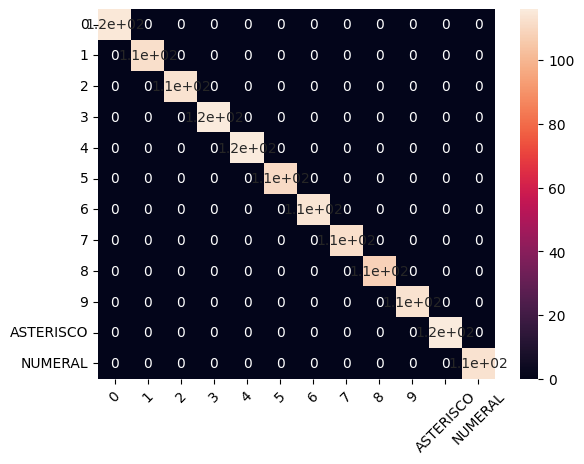

In [22]:
# Ploteamos la matriz de confusion que nos dice visualmente donde y como se equivoca la red al clasificar
# Una matriz diaganonal es un clasificador perfecto

df_cm = pd.DataFrame(data_conf_mat, index = [str(i) for i in tones_dict.keys()],
                  columns = [str(i) for i in tones_dict.keys()])
plt.figure(dpi = 100)
sn.heatmap(df_cm, annot=True)
ax = plt.gca()
ax.tick_params(axis='x', labelrotation=45)
ax.tick_params(axis='y', labelrotation=0)
plt.show()

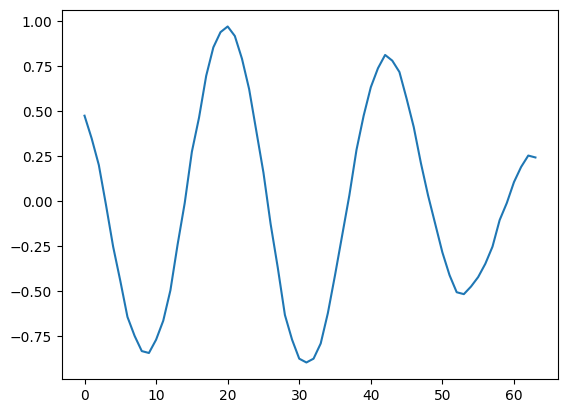

In [23]:
# Para que tengamos una idea, esto es todo lo que la red necesito ver:
plt.figure(dpi = 100)
plt.plot(sample[0][0,:])
plt.show()